# Team composed by:
- Agostara Nicolò
- Fratti Giorgio
- Fusillo Antonio
- Protti Edoardo

### THEORETICAL FRAMEWORK

The dataset contains ratings of items by users

For each couple $(u, i)$ of a user and a item, we consider
the discrete random variable $R(u, i)$ = "item i is relevant for user u"
$R(u, i) \in \{0, 1\}$ for every $u, i$
In this scenario "relevant" doesn't assume the usual meaning
it refers to a "relevance" by a reccomender system point of view

If a user u rated an item i, then he interacted with it,
in this case we assume to have a realization $r(u, i) = 1 \text{ of } R(u, i)$

Since we only have items ratings in our dataset, we don't have any "negative"
realization of $R(u, i)$, i.e. any realization $r(u, i) = 0$

For this reason we make a sampling from the unrealized variables, i.e
the variables $R(u, i)$ such in our dataset there is not a rating of item i by user u

Given our final dataset, consisting in realizations of a subset of the variables $\{R(u, i): \text{u user, i item}\}$
we want to maximize the likelihood function of the model, i.e.
$$L = \prod p(R(u, i) = r(u, i)) = (\prod_{i+} p(R(u, i) = 1)) \times (\prod_{i-} p(R(u, i) = 0)$$ 
splitting the products between positive and negative realizations

Our model returns the value $f(u, i) = p(R(u, i) = 1)$ i.e. the "probability of relevance of item i for user u"
Passing to maximize the log likelihood function we want to maximize:
$$
\begin{aligned}
\log L &= \sum_{u,i} \log p(R(u, i) = 1) + \sum_{u,i} \log p(R(u,i) = 0)\\
&= \sum_{u,i} \log p(R(u, i) = 1) + \sum_{u,i} \log (1 - p(R(u, i) = 1))\\
&= \sum_{u,i} \log f(u, i) + \sum_{u,i} \log (1 - f(u, i))\\
&= ... =\mathrm{BCE}(f)
\end{aligned}
$$

In [2]:
import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from neumf import NeuMF

# Preliminary Definitions

## PATH definition

In [4]:
PATH = "./ml-100k/u.data"
MODEL_PATH = "./models/"

## Parameters definition

In [180]:
args = {
    "seed": 42,
    "lr": 0.001,
    "dropout": 0.2,
    "batch_size": 256,
    "epochs": 30,
    "top_k": 10,
    "num_factors": 32,
    "layers": (32, 16, 8),
    "out": True,
}

In [3]:
np.random.seed(args["seed"])
torch.manual_seed(args["seed"])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

## Evaluation Metrics

In [179]:
def hit(ng_item, pred_items):
    return 1 if ng_item in pred_items else 0


def ndcg(ng_item, pred_items):
    if ng_item in pred_items:
        index = pred_items.index(ng_item)
        return np.reciprocal(np.log2(index + 2))
    return 0


def metrics(model, test_loader, top_k, device):
    HR, NDCG = [], []

    for user, item, label in test_loader:
        user = user.to(device)
        item = item.to(device)

        predictions = model(user, item)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        ng_item = item[0].item()  # leave one-out evaluation has only one item per user
        HR.append(hit(ng_item, recommends))
        NDCG.append(ndcg(ng_item, recommends))

    return np.mean(HR), np.mean(NDCG)


# Data preprocessing

### Torch Dataset classes definitions
- One class for the Training set
- One class for the Validation Set
- One class for the Union between Train and Validation Set (we have not trained the model on this Dataset)
- One class for the Test Set

In [6]:
# Train dataset is {train_positive} Union {train_negative}
class TrainDataset(Dataset):
    def __init__(self, table):
        self.interactions = []
        
        for _, user_id, _, train_positive, _, train_negative, _, _ in table.itertuples():

            # Positive interactions
            for item in train_positive:
                self.interactions.append((user_id, item, 1.0))

            # Negative interactions
            for item in train_negative:
                self.interactions.append((user_id, item, 0.0))

    def __len__(self):
        return len(self.interactions)

    def __getitem__(self, idx):
        user, item, rel = self.interactions[idx]
        user_id = torch.tensor(user, dtype = torch.long)
        item_id = torch.tensor(item, dtype = torch.long)
        relevance = torch.tensor(rel, dtype = torch.float)
        return user_id, item_id, relevance


# Validation dataset is {valid_positive} Union {valid_negative}
class ValidationDataset(Dataset):
    def __init__(self, table):
        self.interactions = []
        
        # For each user
        for _, user_id, _, _, _, _, valid_positive, valid_negative in table.itertuples():

            # Positive interactions
            for item in valid_positive:
                self.interactions.append((user_id, item, 1.0))

            # Negative interactions
            for item in valid_negative:
                self.interactions.append((user_id, item, 0.0))

    def __len__(self):
        return len(self.interactions)

    def __getitem__(self, idx):
        user, item, rel = self.interactions[idx]
        user_id = torch.tensor(user, dtype = torch.long)
        item_id = torch.tensor(item, dtype = torch.long)
        relevance = torch.tensor(rel, dtype = torch.float)
        return user_id, item_id, relevance


# Complete train dataset is {train_positive} Union {train_negative} Union {valid_positive} Union {valid_negative}
class CompleteTrainDataset(Dataset):
    def __init__(self, train: TrainDataset, valid: ValidationDataset):
        self.interactions = train.interactions + valid.interactions

    def __len__(self):
        return len(self.interactions)

    def __getitem__(self, idx):
        user, item, rel = self.interactions[idx]
        user_id = torch.tensor(user, dtype = torch.long)
        item_id = torch.tensor(item, dtype = torch.long)
        relevance = torch.tensor(rel, dtype = torch.float)
        return user_id, item_id, relevance


# Test dataset is {test_positive} Union {100 random samples from unknown}
class TestDataset(Dataset):
    def __init__(self, table, num_unknown=100):
        self.interactions = []
        
        for _, user_id, test_positive, _, unknown, _, _, _ in table.itertuples():

            # Positive interactions
            for item in test_positive:
                self.interactions.append((user_id, item, 1.0))

            # Unknown interactions
            for item in random.sample(list(unknown), num_unknown):
                self.interactions.append((user_id, item, np.nan))

    def __len__(self):
        return len(self.interactions)

    def __getitem__(self, idx):
        user, item, rel = self.interactions[idx]
        user_id = torch.tensor(user, dtype = torch.long)
        item_id = torch.tensor(item, dtype = torch.long)
        relevance = torch.tensor(rel, dtype = torch.float)
        return user_id, item_id, relevance

In [7]:
def get_num_users_items(path):
    ratings = pd.read_csv(
        path,
        sep="\t",
        names=["user_id", "item_id", "rating", "timestamp"],
    )
    return (ratings["user_id"].nunique(), ratings["item_id"].nunique())


## Comment on how we build the dataset
We followed a different approach than the one used in classroom. Since there are a lot of users with more than 200 ratings, sampling their negative interactions as 4 times the number of positive would have produced a lot of redundance in the data. So we actually sample a variable number of negative interactions for each user, depending on how many items he has interacted with: the more the positive interactions, the less negative interactions we sample.
The resulting dataset has a ratio of positive interactions to negative interactions of about 1:1
This means also that the metrics we use will have different scale comparison w.r.t. the results obtained in classroom.

In [8]:
def data_loaders_from_data(path, batch_size):
    ratings = pd.read_csv(path,
                        sep = '\t',
                        names = ['user_id', 'item_id', 'rating', 'timestamp'],
                        )
    
    num_users = ratings['user_id'].nunique()
    num_items = ratings['item_id'].nunique()

    known_positive_size_list = list(ratings.groupby('user_id').size())

    # I want user indexing to start from 0
    ratings['user_id'] = ratings['user_id'] - 1

    # I want item indexing to start from 0
    ratings['item_id'] = ratings['item_id'] - 1

    # For each user consider the set of items of which we know he interacted with
    relevance_table = ratings.groupby('user_id')['item_id'].apply(set).reset_index().rename(columns = {'item_id': 'known_positive'})

    # Set of all items
    items_set = set(range(num_items))

    # For each user consider the set of items of which we have NO interaction information
    relevance_table['unknown'] = relevance_table['known_positive'].apply(lambda x: items_set - x)

    # We don't know any negative interaction
    # We create them by sampling:

    # For each user
    #     Random sample items for each known_positive
    #     Assume that the probability of interaction for those items with the user is 0.0

    # How many negative interactions to add for each user
    def num_ng(user_id):
        known_positive_size = known_positive_size_list[user_id]
        if known_positive_size <= 50:
            return known_positive_size * 4
        if known_positive_size <= 100:
            return known_positive_size * 2
        if known_positive_size <= 200:
            return known_positive_size
        return 10

    relevance_table['known_negative'] = relevance_table.apply(lambda row: set(random.sample(list(row['unknown']), num_ng(row['user_id']))), axis = 'columns')
    relevance_table['unknown']  = relevance_table['unknown'] - relevance_table['known_negative']

    # Put aside the last known positive interactions for testing models(i.e. leave-one-out evaluation method)
    # How to do it:

    #     Add column ranking how old is the interaction
    ratings['oldness'] = ratings['timestamp'].groupby(ratings['user_id']).rank(method = 'first', ascending = False)

    #     Get the most recent interaction for each user
    most_recent_interactions = ratings.groupby('oldness').get_group(1.0)

    #     Create column to add to relevance_table
    last_known_positive = most_recent_interactions.groupby('user_id')['item_id'].apply(set).reset_index().rename(columns = {'item_id': 'last_known_positive'})

    #     Add the column
    relevance_table = pd.merge(last_known_positive, relevance_table, on = 'user_id')
    relevance_table['known_positive'] = relevance_table['known_positive'] - relevance_table['last_known_positive']

    # Rename some columns
    relevance_table.rename(columns = {'last_known_positive' : 'test_positive', 'known_positive': 'train_positive', 'known_negative': 'train_negative'}, inplace='True')

    # Validation data
    relevance_table['validation'] = relevance_table.apply(lambda row: set(random.sample(list(row['train_positive'] | row['train_negative']), 1)), axis = 'columns')

    relevance_table['valid_positive'] = relevance_table.apply(lambda row: row['validation'] & row['train_positive'], axis = 'columns')
    relevance_table['valid_negative'] = relevance_table.apply(lambda row: row['validation'] & row['train_negative'], axis = 'columns')

    relevance_table['train_positive']  = relevance_table['train_positive'] - relevance_table['validation']
    relevance_table['train_negative']  = relevance_table['train_negative'] - relevance_table['validation']

    relevance_table.drop(columns = 'validation', inplace = True)

    #print(relevance_table)

    train_dataset = TrainDataset(relevance_table)
    validation_dataset = ValidationDataset(relevance_table)

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    valid_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = True)
    complete_train_loader = DataLoader(CompleteTrainDataset(train_dataset, validation_dataset), batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(TestDataset(relevance_table), batch_size = 101, shuffle = False)

    return train_loader, valid_loader, complete_train_loader, test_loader

In [9]:
train_loader, valid_loader, complete_train_loader, test_loader = data_loaders_from_data(PATH, batch_size=256)
num_users, num_items = get_num_users_items(PATH)
train_loader

# Models Definition


### Training function for GMF and MLP models

In [11]:
# Trains and save the model and returns the lists of train_loss and validation_loss
def train_model(model: nn.Module, train_loader: DataLoader, valid_loader: DataLoader):
    model = model.to(device)

    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args["lr"])

    # train, evaluation
    best_valid_loss = math.inf
    train_loss, valid_loss = [], []

    for epoch in tqdm(range(args["epochs"])):
        model.train()  # Enable dropout (if present).

        intermediate_train_loss = []
        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            loss.backward()
            optimizer.step()
            intermediate_train_loss.append(loss.cpu().detach().item())

        train_loss.append(np.mean(intermediate_train_loss))
        model.eval()

        intermediate_valid_loss = []
        for user, item, label in valid_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            prediction = model(user, item)
            loss = loss_function(prediction, label)

            intermediate_valid_loss.append(loss.cpu().detach().item())

        valid_loss.append(np.mean(intermediate_valid_loss))
        if valid_loss[epoch] < best_valid_loss:
            best_valid_loss = valid_loss[epoch]
            if args["out"]:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(
                    model,
                    f"{MODEL_PATH}{model.__class__.__name__}{model.factor_num}.pt",
                )

    losses = pd.DataFrame({"train loss": train_loss, "valid loss": valid_loss})
    losses.to_csv(f"{MODEL_PATH}{model.__class__.__name__}{model.factor_num}.csv")
    return train_loss, valid_loss


## General Matrix Factorization (GMF)

In [12]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.num_factors
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.num_factors
        )

        self.affine_output = nn.Linear(in_features=self.num_factors, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()

### Training and save of GMF model

In [120]:
gmf_model = GMF(num_users, num_items)
train_loss, valid_loss = train_model(gmf_model, train_loader, valid_loader)

100%|██████████| 30/30 [02:03<00:00,  4.11s/it]


## Multi Layer Perceptron (MLP)

In [14]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]
        self.layers = args["layers"]

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.num_factors)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.num_factors)

        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(self.num_factors*2, self.layers[0]))

        for in_size, out_size in zip(self.layers[:-1], self.layers[1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))

                                
        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            # vector = nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

### Training and Save of MLP model

In [119]:
mlp_model = MLP(num_users, num_items)
train_loss, valid_loss = train_model(mlp_model, train_loader, valid_loader)

100%|██████████| 30/30 [02:19<00:00,  4.65s/it]


# Task 1 - Neural Matrix Factorization

## HyperParameter Tuning With RayTune
If there is a need for a more detailed description of how to use and configure the Hyper Parameter Tuning procedure we will provide them in the next version of the notebook.

### We first need to define a config dict that defines the search space of the hyperparameters

In [16]:
config = {
    "lr": tune.choice([0.005, 0.015, 0.01, 0.001]),
    "batch_size": tune.choice([128, 256, 512]),
    "num_factors": tune.choice([8, 16, 32]),
    "epochs": tune.choice([15, 30, 40]),
    "out": True,
    "layers": tune.choice([[32, 16, 8], [64, 32, 8]]),
    "dropout": np.random.choice([0, 0.2, 0.5], size=(7, 20), p=[0.5, 0.3, 0.2])
}

### Train Function
We have to define a train function that takes as argument the config file.
This function will:
- Initialize NeuMF model with the specified config parameters (num factors, layers, dropout vector for the different layers)
- Initialize Train and validation dataloaders
- Train the model on the Train dataloader
- Evaluate the validation loss and report it to RayTune
- Save the best model


In [17]:
#trains and save the model and returns the lists of train_loss and validation_loss 
def train_NeuMF(config):
    #model = NeuMF_parametric_dropout(config['num_factors'], num_users, num_items, config['layers'], config['dropout'])
    model = NeuMF(config['num_factors'], num_users, num_items, config['layers'], config['dropout'])

    train_loader, valid_loader, _, _ = data_loaders_from_data(PATH, batch_size = config['batch_size'])

    model = model.to(device)

    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    # train, evaluation
    best_valid_loss = math.inf
    train_loss, valid_loss = [], []

    for epoch in range(config['epochs']):
        model.train() # Enable dropout (if have).

        intermediate_train_loss = []
        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            loss.backward()
            optimizer.step()
            intermediate_train_loss.append(loss.cpu().detach().item())
            #writer.add_scalar('loss/Train_loss', loss.item(), epoch)

        train_loss.append(np.array(intermediate_train_loss).mean())

        model.eval()

        intermediate_valid_loss = []
        for user, item, label in valid_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            prediction = model(user, item)
            loss = loss_function(prediction, label)

            intermediate_valid_loss.append(loss.cpu().detach().item())

        valid_loss.append(np.array(intermediate_valid_loss).mean())
        if valid_loss[epoch] < best_valid_loss:
            best_valid_loss = valid_loss[epoch]
            if config['out']:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(model, 
                    '{}{}{}.pt'.format(MODEL_PATH, model.__class__.__name__, model.factor_num))
                
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        tune.report(loss = valid_loss[epoch])
                
    losses = pd.DataFrame({"train loss":train_loss, "valid loss": valid_loss}, index=range(1, config['epochs']+1))
    losses.to_csv('{}{}{}'.format(MODEL_PATH, model.__class__.__name__, model.factor_num))
    return train_loss, valid_loss


### Initialize the scheduler and running the HT procedure
There is a paper related to the ASAH Scheduler at :https://arxiv.org/abs/1810.05934

In [18]:
scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=40,
        grace_period=5,
        reduction_factor=2)

reporter = CLIReporter(
        metric_columns=["loss"]
)

In [ ]:
result = tune.run(
    train_NeuMF,
    local_dir="./checkpoints/",
    resources_per_trial={"cpu": 8},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=reporter,
    checkpoint_at_end=False,
)

In [ ]:

best_trial = result.get_best_trial("loss", "min", "last")
best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))

best_trained_model = NeuMF(best_trial.config["num_factors"], num_users, num_items, best_trial.config["layers"], best_trial.config['dropout']) 

best_trained_model.load_state_dict(model_state)
torch.save(best_trained_model, '{}{}{}_best_so_far.pt'.format(MODEL_PATH, best_trained_model.__class__.__name__, best_trained_model.factor_num))

best_trial.config

### Reporting the best configuration in our tests

In [19]:
best_config = {
    "lr": 0.01,
    "batch_size": 256,
    "num_factors": 8,
    "epochs": 20,
    "out": True,
    "layers": (64, 16, 8),
    "dropout": (0, 0, 0, 0, 0, 0, 0.5),
}

# Task 2 - Models Evaluation

In [20]:
def plot_losses(model: nn.Module, train_loss, valid_loss, ax: plt.Axes):
    ax.plot(range(1, len(train_loss) + 1), train_loss, label="Training", color="blue")
    ax.plot(range(1, len(valid_loss) + 1), valid_loss, label="Validation", color="red")
    ax.legend()
    ax.set_title(
        f"{model.__class__.__name__} losses with {model.factor_num} num factors"
    )
    ax.set_xticks(range(1, len(train_loss) + 1, step=2))
    ax.set_ylim(0.0, 0.7)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("BCE Loss")
    return ax


## Validation set error of the three models

We are aware of the fact that the NeuMF validation loss curve is very bad but this model configuration is the one that performs better (among the ones tested) with the Hit Rate metric and The Normalized Discounted Cumulative Gain.

A lower learning rate provide a better validation loss curve but lower metrics performances

In [181]:
gmf_model = torch.load(MODEL_PATH + "GMF32.pt", map_location = device)
gmf_losses = pd.read_csv(MODEL_PATH + "GMF32", index_col = 0)

mlp_model = torch.load(MODEL_PATH + "MLP32.pt", map_location = device)
mlp_losses = pd.read_csv(MODEL_PATH + "MLP32", index_col = 0)

nmf_model = torch.load(MODEL_PATH + "NeuMF8.pt", map_location = device)
nmf_losses = pd.read_csv(MODEL_PATH + "NeuMF8", index_col = 0)

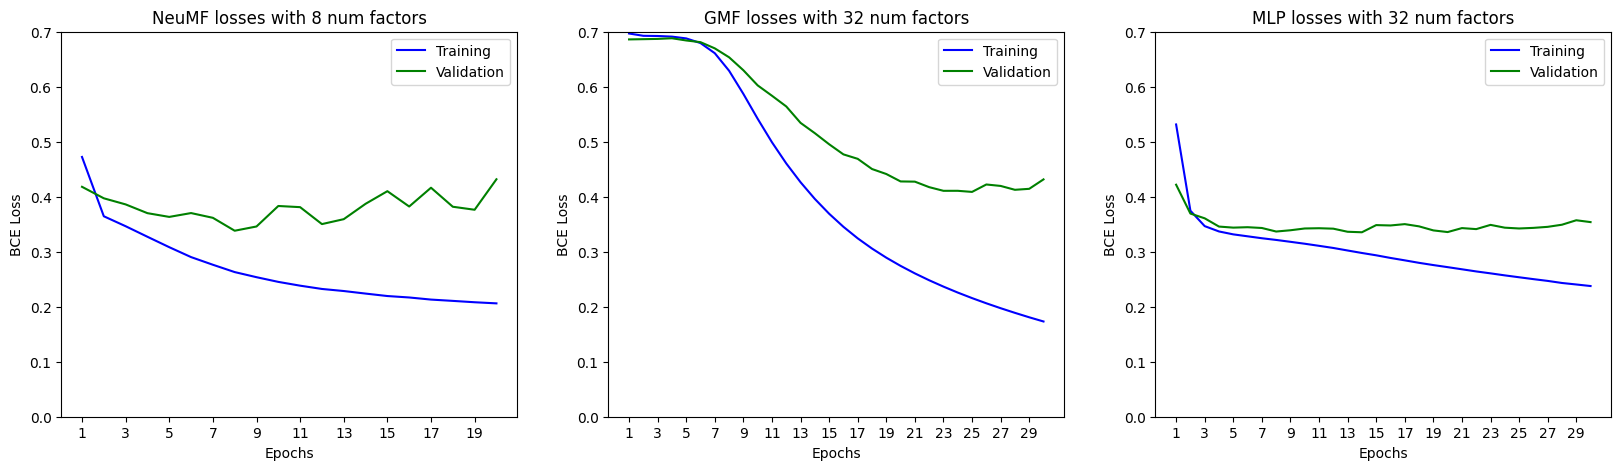

In [182]:
fix, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5))
ax1 = plot_losses(nmf_model, nmf_losses['train loss'], nmf_losses['valid loss'], ax1)
ax2 = plot_losses(gmf_model, gmf_losses['train loss'], gmf_losses['valid loss'], ax2)
ax3 = plot_losses(mlp_model, mlp_losses['train loss'], mlp_losses['valid loss'], ax3)


## HR and NDCG Metrics evaluation
We have evaluated those metrics while the number of recommendations k vary, we have reported that the best models of NeuMF is with 8 num factors so we take into consideration that model, in the next session different models with different num factors will be evaluated

In [183]:
from tqdm import tqdm
import pandas as pd

def model_evaluation(models_dict, test_loader, k_range = range(5, 15), device = torch.device("cpu")): #the function expects a dict {"model name": model}
  for key in models_dict:
    models_dict[key] = models_dict[key].to(device)

  HR = np.zeros((len(k_range), len(models_dict)))
  NDCG = np.zeros((len(k_range), len(models_dict)))
  for k in tqdm(range(0, k_range.stop - k_range.start)):
    for model_index, key in enumerate(models_dict):
      HR[k, model_index], NDCG[k, model_index] = metrics(models_dict[key], test_loader, k + 1, device)

  HR_result = pd.DataFrame(data = HR, columns = models_dict.keys(), index = k_range)
  NDCG_result = pd.DataFrame(data = NDCG, columns = models_dict.keys(), index = k_range)
  return HR_result, NDCG_result

In [184]:
mlp_model = torch.load(MODEL_PATH + "MLP32.pt", map_location = device)
gmf_model = torch.load(MODEL_PATH + "GMF32.pt", map_location = device)
nmf_model = torch.load(MODEL_PATH + "NeuMF8.pt", map_location = device)
mlp_model = mlp_model.to(device)
gmf_model = gmf_model.to(device)
nmf_model = nmf_model.to(device)


In [185]:
models_dict = {"GMF": gmf_model, "MLP": mlp_model, "NeuMF": nmf_model}
HR, NDCG = model_evaluation(models_dict, test_loader, device = device, k_range= range(7, 15))

100%|██████████| 8/8 [00:35<00:00,  4.43s/it]


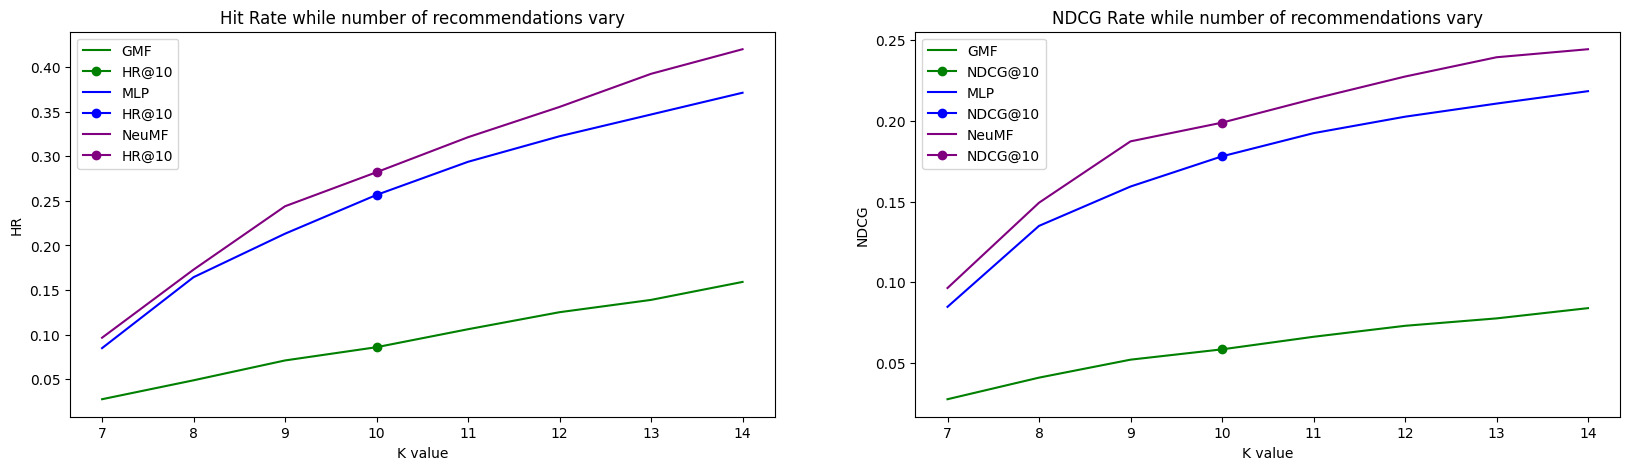

In [186]:
import matplotlib.pyplot as plt
fig, (hr_ax, ndcg_ax) = plt.subplots(1,2, figsize = (20, 5))
colors = ["green", "blue", "purple"]
for num, i in enumerate(HR.columns):
  hr_ax.plot(HR[i], label = i, color = colors[num])
  ndcg_ax.plot(NDCG[i], label = i, color = colors[num])
  hr_ax.plot([10],[HR[i][10]], marker = "o", color = colors[num], label = "HR@10")
  ndcg_ax.plot([10],[NDCG[i][10]], marker = "o", color = colors[num], label = "NDCG@10")


hr_ax.set_title("Hit Rate while number of recommendations vary")
ndcg_ax.set_title("NDCG Rate while number of recommendations vary")
hr_ax.set_ylabel("HR")
hr_ax.set_xlabel("K value")
ndcg_ax.set_ylabel("NDCG")
ndcg_ax.set_xlabel("K value")
hr_ax.legend()
ndcg_ax.legend()
plt.show()

# Task 3 - Metrics Evaluation while num factors vary

In [188]:
num_factors = [8, 16, 32, 64]
#do not change the order of HR and NDCG matrices
model_names = ["GMF Model", "MLP Model", "NeuMF model"]
mlp_models, gmf_models, nmf_models = {}, {}, {}

#I create a dict containing as the key the num_factor and as a value the relative model 
for num in num_factors:
    mlp_models[num] = torch.load(MODEL_PATH + "MLP{}.pt".format(num), map_location = device)
    gmf_models[num] = torch.load(MODEL_PATH + "GMF{}.pt".format(num), map_location = device)
    nmf_models[num] = torch.load(MODEL_PATH + "NeuMF{}.pt".format(num), map_location = device)

In [190]:
HR, NDCG = list([]), list([])

#for each num factor and for each model I compute the provided metrics on the test set
for num in tqdm(num_factors):
    hr_gmf, ndcg_gmf = metrics(gmf_models[num], test_loader, 10, device)
    hr_mlp, ndcg_mlp = metrics(mlp_models[num], test_loader, 10, device)
    hr_nmf, ndcg_nmf = metrics(nmf_models[num], test_loader, 10, device)
    HR.append([hr_gmf, hr_mlp, hr_nmf])
    NDCG.append([ndcg_gmf, ndcg_mlp, ndcg_nmf])

100%|██████████| 4/4 [00:17<00:00,  4.49s/it]


In [191]:
#Here I transpose the matrices because I need to have on the same row the results of the metrics for the same model (in order to construct the bar plot)
HR = np.array(HR).T
NDCG = np.array(NDCG).T

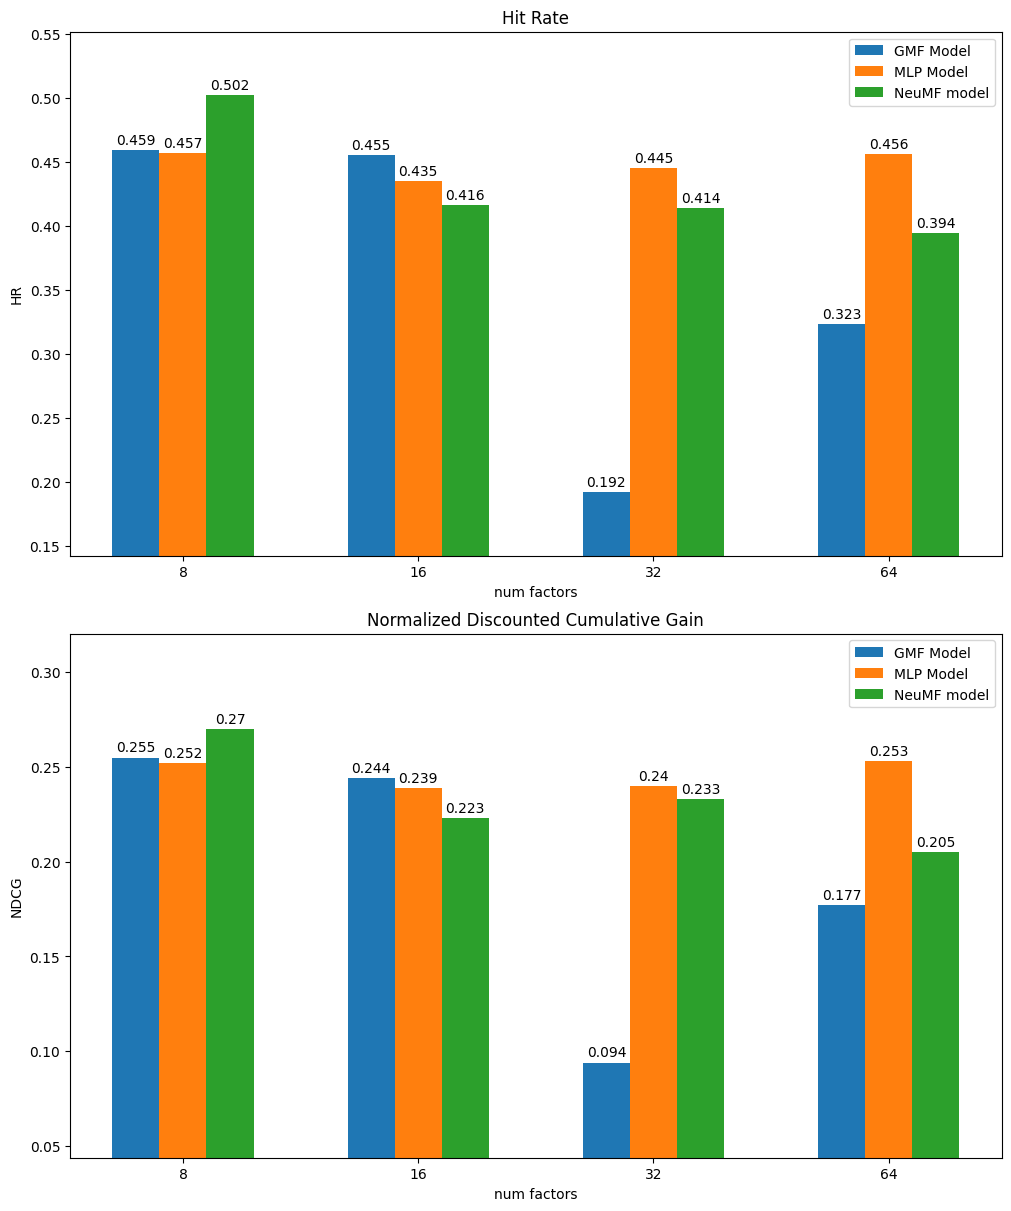

In [195]:
from matplotlib.container import BarContainer 
fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained', figsize = (10,12))
x = np.arange(HR.shape[1])
offset = -0.2
for i in range(len(HR)):
    rects1 = ax1.bar(x + offset, np.round(HR[i], 3), width=0.2, label = model_names[i])
    rects2 = ax2.bar(x + offset, np.round(NDCG[i], 3), width=0.2, label = model_names[i])
    ax1.bar_label(rects1, padding = 2)
    ax2.bar_label(rects2, padding = 2)
    offset += 0.2

ax1.set_ylim(min(HR.reshape(-1,1)) - 0.05, max(HR.reshape(-1,1)) + 0.05)
ax2.set_ylim(min(NDCG.reshape(-1,1)) - 0.05, max(NDCG.reshape(-1,1)) + 0.05)

ax1.set_xticks(x)
ax1.set_ylabel("HR")
ax1.set_xticklabels(num_factors)
ax1.set_xlabel("num factors")


ax2.set_xticks(x)
ax2.set_ylabel("NDCG")
ax2.set_xlabel("num factors")
ax2.set_xticklabels(num_factors)

ax1.set_title("Hit Rate")
ax2.set_title("Normalized Discounted Cumulative Gain")

ax1.legend()
ax2.legend()

